# Imports

In [15]:
import time

import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector

from application import (
    BURR_DOCS_DIR,
    DEVICE,
    DOCS_LIMIT,
    EMS_MODEL,
    LANCE_URI,
    add_table,
    assistant_message,
    evaluator_template,
    exa_search_query_template,
    get_user_query,
    lancedb_query_template,
    load_burr_docs,
    route_template,
    user_message,
)
from application import application as adaptive_crag_app

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Add Burr Docs to LanceDB 

In [ ]:
# sentence-transformers model for embeddings
lance_model = (
    get_registry().get("sentence-transformers").create(name=EMS_MODEL, device=DEVICE)
)


# define the schema of your data using Pydantic
class LanceDoc(LanceModel):
    text: str = lance_model.SourceField()
    vector: Vector(dim=lance_model.ndims()) = lance_model.VectorField()  # type: ignore
    file_name: str


lance_db = lancedb.connect(LANCE_URI)

In [3]:
burr_docs = load_burr_docs(burr_docs_dir=BURR_DOCS_DIR)

Merging 11 docs
Merged to 4 docs

Merging 47 docs
Merged to 12 docs

Merging 7 docs
Merged to 3 docs

Merging 10 docs
Merged to 3 docs

Merging 34 docs
Merged to 9 docs



In [4]:
burr_table = add_table(
    db=lance_db, table_name="burr_docs", data=burr_docs, schema=LanceDoc
)

## Run Hybrid Search

In [5]:
res = (
    burr_table.search(query="expr", query_type="hybrid")
    .limit(limit=DOCS_LIMIT)
    .to_pandas()
)
res.text.tolist()

['The ~ operator will invert a condition. For instance:\nfrom burr.core import when, expr\nwith_transitions(\n    ("from", "to", ~when(foo="baz"),  # will evaluate to True when foo != baz\n    ("from", "to", ~expr(\'epochs<=100\')) # will evaluate to True when epochs hits 101\n)\nAll keys present in the condition (E.G. foo and epochs above) must be present in the state for the condition to work. It will error otherwise.\nNote\nThe default condition is a special case, and will always evaluate to True. It is useful for defining a “catch-all” transition that will be selected if no other condition is met. If you pass a tuple of length 2 to with_transitions, the default condition will be used.',
 'Conditions\nConditions have a few APIs, but the most common are the three convenience functions:\nfrom burr.core import when, expr, default\nwith_transitions(\n    ("from", "to", when(foo="bar"),  # will evaluate when the state has the variable "foo" set to the value "bar"\n    ("from", "to", expr

# Prompts

In [8]:
query = "What are actions in Burr?"

## Router

In [9]:
print(
    route_template(
        table_names=lance_db.table_names(),
        query=query,
        chat_history=[user_message("hello"), assistant_message("hi")],
    )
)

<task>
You are a world-class router for user queries.
Given a user query, you may need some extra information for answering the query. So you need to select the best place to find the answer.
You have the following options:
1. You will have some vectorstore tables with information on specific topics. If the query is directly related to any of these topics, return the relevant table name.
2. If you can answer the query directly with your own knowledge, return "assistant".
3. If you don't have the answer to the query, you can search the internet for the answer. In this case, return "web_search".
</task>

<available_tables>
burr_docs
</available_tables>

<chat_history>
user: hello
assistant: hi
</chat_history>

<query>
What are actions in Burr?
</query>


## Rewrite Query
Our AI will return an object of this in response:
```python
class LanceDBQuery(BaseModel):
    keywords: list[str] = Field(..., min_length=1, max_length=10)
    query: str = Field(..., min_length=10, max_length=300)

    def __str__(self) -> str:
        return ", ".join(self.keywords) + ", " + self.query
```

In [11]:
print(lancedb_query_template(query=query))

<task>
You are a world-class researcher with access to a vectorstore that can be one of or similar to ChromaDB, Weaviate, LanceDB, VertexAI, etc.
Given a user query, rewrite the query to find the most relevant information in the vectorstore.
Remember that the vectorstore has hybrid search capability, which means it can do both full-text search and vector similarity search.
So make sure to not remove any important keywords from the query. You can even add more keywords if you think they are relevant.
Split the query into a list of keywords and a string query.
</task>

<query>
What are actions in Burr?
</query>



## Extract Web Search Keywords
Our AI will return an object of this in response:
```python
class ExaSearchKeywords(BaseModel):
    keywords: list[str] = Field(..., min_length=2, max_length=5)

    def __str__(self) -> str:
        return ", ".join(self.keywords)
```


In [14]:
print(exa_search_query_template(query=query))

<task>
You are a world-class internet researcher.
Given a user query, extract 2-5 keywords as queries for the web search. Including the topic background and main intent.
</task>

<examples>

<query>
What is Henry Feilden’s occupation?
</query>
<keywords>
Henry Feilden, occupation
</keywords>

<query>
In what city was Billy Carlson born?
</query>
<keywords>
city, Billy Carlson, born
</keywords>

<query>
What is the religion of John Gwynn?
</query>
<keywords>
religion, John Gwynn
</keywords>

<query>
What sport does Kiribati men’s national basketball team play?
</query>
<keywords>
sport, Kiribati men’s national basketball team play
</keywords>

</examples>

<query>
What are actions in Burr?
</query>



## Evaluate Document Relevance

In [16]:
print(evaluator_template(query=query, document="Actions are when things go burrr"))

<task>
You are a world-class document relevance evaluator.
Given a user query, does the following document have the exact information to answer the question? Answer True or False.
</task>

<query>
What are actions in Burr?
</query>

<document>
Actions are when things go burrr
</document>



# Application

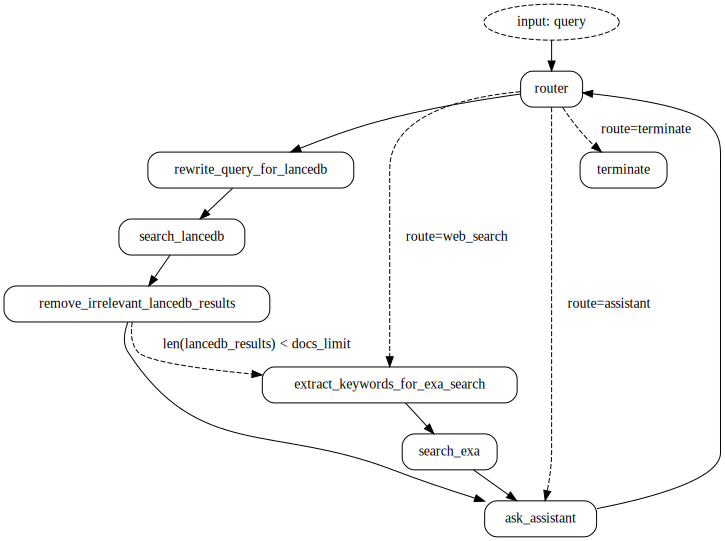

In [6]:
app = adaptive_crag_app(db=lance_db)
app.visualize(
    output_file_path="statemachine",
    include_conditions=True,
    include_state=False,
    format="png",
)

In [ ]:
inputs = {"query": get_user_query()}
while True:
    action, result, state = app.step(inputs=inputs)  # type:ignore
    print(f"\nRESULT: {result}\n")
    if action.name == "terminate":
        break
    elif action.name == "ask_assistant":
        time.sleep(1.5)
        inputs = {"query": get_user_query()}